# FRA 503: Deep Reinforcement Learning Cart Pole [ HW3 ]

## 65340500062 Aitthikit Kitcharoennon

## Learning Objectives:

-   Understand how function approximation works and how to implement it.

-    Understand how policy-based RL works and how to implement it.

-    Understand how advanced RL algorithms balance exploration and exploitation.

-    Be able to differentiate RL algorithms based on stochastic or deterministic policies, as well as value-based, policy-based, or Actor-Critic approaches.

-    Gain insight into different reinforcement learning algorithms, including Linear Q-Learning, Deep Q-Network (DQN), the REINFORCE algorithm, and the Actor-Critic algorithm. Analyze their strengths and weaknesses.


## Part 1: Understanding the Algorithm

In this homework, will implement 4 different function approximation-based RL algorithms:

### Linear Q-Learning (Value-based)

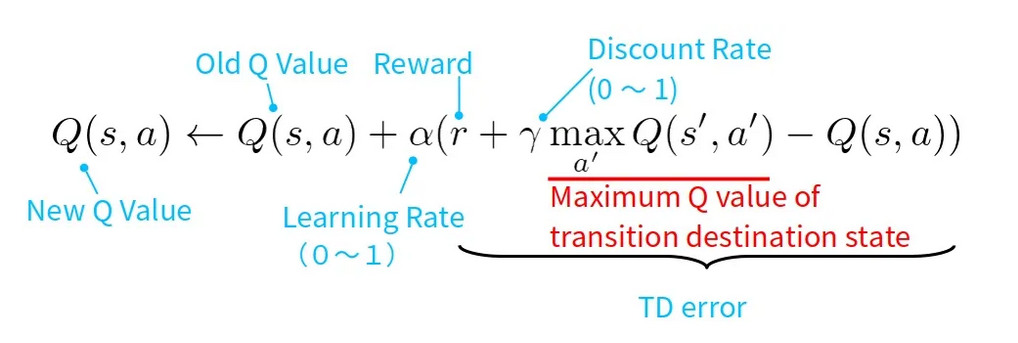

Ref:https://itsudit.medium.com/the-q-in-q-learning-a-comprehensive-guide-to-this-powerful-reinforcement-learning-algorithm-896cbbedcd33

Linear Q-Learning
- Use Q values like normal Q-learning but the Q value is approximated by 
$$
Q(s, a) = \mathbf{w}_a^T \boldsymbol{\phi}(s)
$$

- $\mathbf{w}_a$ : Weight vector for action
- $\boldsymbol{\phi}(s)$ : Feature vector devived from the state s

Linear model are learning from a seperate weight vector for each action.

### Deep Q-Network (DQN) (Value-based)

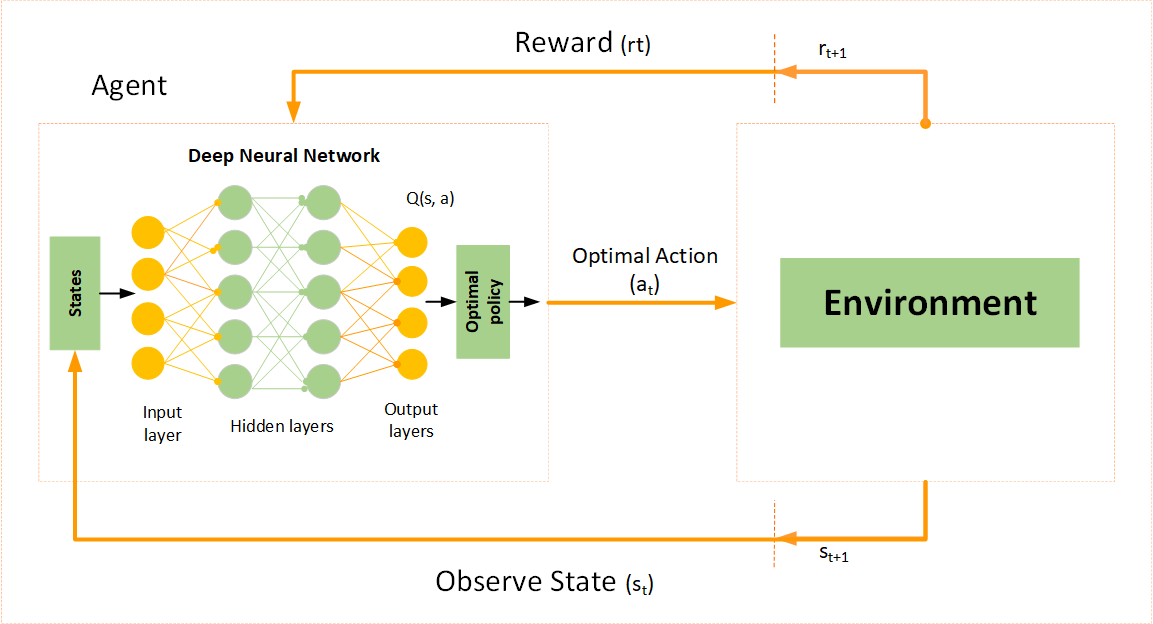

Ref:https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae

Deep Q-Network
- Use Q values like normal Q-learning but the Q-value function is approximated by Deep neural network
$$
Q(s, a; \theta) = Q^*(s,a)
$$

- $s$ : State
- $a$ : action
- $\theta$ : neural network weight

model are learning from a stored experience (s,a,r,s′) in a replay buffer and Samples a mini-batch of experiences and updates the network using:
$$
target = r + \gamma\max_{a'} Q(s', a',\theta^-)
$$
$$
\mathcal{L} = (Q(s, a,\theta)-target)
$$
$$
\mathcal{L}(\theta) = \mathbb{E}_{(s,a,r,s') \sim D} \left[ \left( r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta) \right)^2 \right]
$$

- $\mathcal{L}$ : Loss function use to train the main network.
- $Q(s, a; \theta)$ : Q-value predicted by the main network.
- $target$ : the target Q-value, using the target network.

### REINFORCE algorithm (Policy-based)

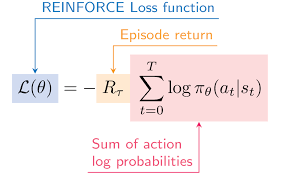

Ref:https://campus.datacamp.com/courses/deep-reinforcement-learning-in-python/introduction-to-policy-gradient-methods?ex=6

MC REINFORCE algorithm
- MC REINFORCE is a Monte Carlo policy gradient algorithm that directly optimizes a policy by using the total return of an episode.

This algorithm are parameterize the policy with a neural network and adjust θ(best parameter) using:
$$
\mathcal{L}(\theta) = - \sum_{t=0}^{T} \log \pi_\theta(a_t \mid s_t) \cdot G_t
$$

- $\mathcal{L}$ : Loss function use to train the main network.
- $G_t$ : return from time t, i.e., the sum of rewards from timestep onward.
- $\log \pi_\theta(a_t \mid s_t)$ : log-probability of the action taken.

### Proximal Policy Optimization (PPO)

## Part 2: Setting up Cart-Pole Agent.

### RL Base Function class

#### Constructor

Number of actions: The total number of discrete actions available to the agent.

Action range: The minimum and maximum values defining the range of possible actions.

Learning rate: Determines how quickly the model updates based on new information.

Initial epsilon: The starting probability of taking a random action in an ε-greedy policy.

Epsilon decay rate: The rate at which epsilon decreases over time to favor exploitation over exploration.

Final epsilon: The lowest value epsilon can reach, ensuring some level of exploration remains.

Discount factor: A coefficient (γ) that determines the importance of future rewards in decision-making.

Buffer size: Maximum number of experiences the buffer can hold.

Batch size: Number of experiences to sample per batch.

hidden_dim: The dimention of the hidden layer in neural network.

dropout: The dropout value for dropout some layer in neural network.

tau: Soft update rate in RL target network.

device: Set device for locate data to compute.


In [ ]:
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.001
hidden_dim = 64
n_episodes = 5000
tau = 0.005
dropout = 0.0
initial_epsilon = 1.0
epsilon_decay = 0.001  
final_epsilon = 0.01
discount = 0.99
buffer_size = 256
batch_size = 1
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

#### scale_action

Using for map action index to action range to step environment.

In [ ]:
def scale_action(self, action):
    """
    Maps a discrete action in range [0, n] to a continuous value in [action_min, action_max].

    Args:
        action (int): Discrete action in range [0, n].
        n (int): Number of discrete actions (inclusive range from 0 to n).
    
    Returns:
        torch.Tensor: Scaled action tensor.
    """
    # ========= put your code here ========= #
    action_min, action_max = self.action_range
    return torch.tensor(action_min + (action_max - action_min) * (action / (self.num_of_action - 1)), dtype=torch.float32)
    # ====================================== #

#### decay_epsilon

Using for decay epsilon value to reduce exploration over time.(in this function using linear epsilon decay because it easy to cal how fast to reduce exploration)

In [ ]:
def decay_epsilon(self):
    """
    Decay epsilon value to reduce exploration over time.
    """
    # ========= put your code here ========= #
    self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    pass
    # ====================================== #

### Replay Buffer Class

A class use to store state, action, reward, next state, and termination status from each timestep in episode to use as a dataset to train neural networks. This class will include:

#### Constructor

In [ ]:
def __init__(self, buffer_size, batch_size = 1):
    """
    Initializes the replay buffer.

    Args:
        buffer_size (int): Maximum number of experiences the buffer can hold.
        batch_size (int): Number of experiences to sample per batch.
    """
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size

#### Core Functions

##### Add

In [ ]:
def add(self, state, action, reward, next_state, done):
    """
    Adds an experience to the replay buffer.

    Args:
        state (Tensor): The current state of the environment.
        action (Tensor): The action taken at this state.
        reward (Tensor): The reward received after taking the action.
        next_state (Tensor): The next state resulting from the action.
        done (bool): Whether the episode has terminated.
    """
    self.memory.append((state, action, reward, next_state, done))

##### sample 

In [ ]:
def sample(self):
    """
    Samples a batch of experiences from the replay buffer.

    Returns:
        - state_batch: Batch of states.
        - action_batch: Batch of actions.
        - reward_batch: Batch of rewards.
        - next_state_batch: Batch of next states.
        - done_batch: Batch of terminal state flags.
    """
    batch = random.sample(self.memory, min(self.batch_size, len(self.memory)))
    return batch

### Algorithm folder

#### Linear Q Learning class

In [ ]:
class Linear_QN(BaseAlgorithm):
    def __init__(
            self,
            num_of_action: int = 2,
            action_range: list = [-2.5, 2.5],
            learning_rate: float = 0.01,
            initial_epsilon: float = 1.0,
            epsilon_decay: float = 0.999,
            final_epsilon: float = 0.001,
            discount_factor: float = 0.95,
    ) -> None:
        self.episode_durations = []
        """
        Initialize the CartPole Agent.

        Args:
            learning_rate (float): The learning rate for updating Q-values.
            initial_epsilon (float): The initial exploration rate.
            epsilon_decay (float): The rate at which epsilon decays over time.
            final_epsilon (float): The final exploration rate.
            discount_factor (float, optional): The discount factor for future rewards. Defaults to 0.95.
        """        
        
        super().__init__(
            num_of_action=num_of_action,
            action_range=action_range,
            learning_rate=learning_rate,
            initial_epsilon=initial_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            discount_factor=discount_factor,
        )
        
        
    def update(
        self,
        obs,
        action: int,
        reward: float,
        next_obs,
        next_action: int,
        terminated: bool
    ):
        """
        Updates the weight vector using the Temporal Difference (TD) error 
        in Q-learning with linear function approximation.

        Args:
            obs (dict): The current state observation, containing feature representations.
            action (int): The action taken in the current state.
            reward (float): The reward received for taking the action.
            next_obs (dict): The next state observation.
            next_action (int): The action taken in the next state (used in SARSA).
            terminated (bool): Whether the episode has ended.

        """
        # ========= put your code here ========= #
        obs_vec = obs["policy"].flatten()
        next_obs_vec = next_obs["policy"].flatten()

        q_next = 0.0 if terminated else self.q(next_obs_vec).max()
        q_target = reward + self.discount_factor * q_next
        q_current = self.q(obs_vec, action)
        td_error = q_target - q_current
        # Update weights
        td_error = td_error.item()  # Convert single-element tensor to float
        obs_vec = obs_vec.detach().cpu().numpy()
        # print(type(obs),type(self.lr),type(td_error),type(obs_vec))
        self.w[:, action] += self.lr * td_error * obs_vec

        # Log error
        self.training_error.append(td_error**2)
        # ====================================== #

    def select_action(self, state):
        """
        Select an action based on an epsilon-greedy policy.
        
        Args:
            state (Tensor): The current state of the environment.
        
        Returns:
            Tensor: The selected action.
        """
        # ========= put your code here ========= #
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_of_action)
        q_vals = self.q(state)
        # print(q_vals)
        return int(np.argmax(q_vals))
        # ====================================== #

    def learn(self, env):
        """
        Train the agent on a single step.

        Args:
            env: The environment in which the agent interacts.
            max_steps (int): Maximum number of steps per episode.
        """

        # ===== Initialize trajectory collection variables ===== #
        # Reset environment to get initial state (tensor)
        # Track total episode return (float)
        # Flag to indicate episode termination (boolean)
        # Step counter (int)
        # ========= put your code here ========= #
        obs,_ = env.reset()
        total_reward = 0.0
        done = False
        timestep = 0

        while not done:
            state = obs['policy']
            action = self.select_action(state)
            scaled_action = self.scale_action(action)
            action_tensor = torch.tensor([[scaled_action]], dtype=torch.float32)
            next_obs, reward, terminated, truncated, _  = env.step(action_tensor)
            next_state = next_obs['policy']
            next_action = self.select_action(next_state)
            self.update(obs, action, reward.item(), next_obs, next_action, done)
            obs = next_obs
            total_reward += reward.item()
            done = terminated or truncated


            timestep += 1
            if done:
                self.plot_durations(timestep)
                break
        self.decay_epsilon()
        return total_reward,timestep
        # ====================================== #

    def plot_durations(self, timestep=None, show_result=False):
        if timestep is not None:
            self.episode_durations.append(timestep)

        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated

#### Deep Q-Network class

In this class i create the neural network 5 layers : 1 input layer,3 hidden layers and 1 output layer and dropout first and second layer

In [ ]:
import random
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions.normal import Normal
from torch.nn.functional import mse_loss
from RL_Algorithm.RL_base_function import BaseAlgorithm
import matplotlib
import matplotlib.pyplot as plt
import os

class QNetwork(nn.Module):
    def __init__(self, input_dim : int, hidden_dim: int, output_dim: int, learning_rate=1e-4,dropout=0.0):
        """
        Actor network for policy approximation.

        Args:
            input_dim (int): Dimension of the state space.(State_dim)
            hidden_dim (int): Number of hidden units in layers.
            output_dim (int): Dimension of the action space.(Actions_dim)
            learning_rate (float, optional): Learning rate for optimization. Defaults to 1e-4.
        """
        super(QNetwork, self).__init__()

        # ========= put your code here ========= #
        self.init_weights()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        # ====================================== #

    def init_weights(self):
        """
        Initialize network weights using Xavier initialization for better convergence.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Xavier initialization
                nn.init.zeros_(m.bias)  # Initialize bias to 0

    def forward(self, state):
        """
        Forward pass for action selection.

        Args:
            state (Tensor): Current state of the environment.

        Returns:
            Tensor: Selected action values.
        """
        # ========= put your code here ========= #
        x = torch.relu(self.fc1(state))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return self.fc4(x)
        # ====================================== #

class DQN(BaseAlgorithm):
    def __init__(self, 
                device = None, 
                num_of_action: int = 2,
                action_range: list = [-2.5, 2.5],
                n_observations: int = 4,
                hidden_dim = 256,
                dropout = 0.05, 
                learning_rate: float = 0.01,
                initial_epsilon: float = 1.0,
                epsilon_decay: float = 1e-3,
                final_epsilon: float = 0.001,
                tau: float = 0.005,
                discount_factor: float = 0.95,
                buffer_size: int = 256,
                batch_size: int = 1,
                ):
        """
        Actor-Critic algorithm implementation.

        Args:
            device (str): Device to run the model on ('cpu' or 'cuda').
            num_of_action (int, optional): Number of possible actions. Defaults to 2.
            action_range (list, optional): Range of action values. Defaults to [-2.5, 2.5].
            n_observations (int, optional): Number of observations in state. Defaults to 4.
            hidden_dim (int, optional): Hidden layer dimension. Defaults to 256.
            learning_rate (float, optional): Learning rate. Defaults to 0.01.
            tau (float, optional): Soft update parameter. Defaults to 0.005.
            discount_factor (float, optional): Discount factor for Q-learning. Defaults to 0.95.
            batch_size (int, optional): Size of training batches. Defaults to 1.
            buffer_size (int, optional): Replay buffer size. Defaults to 256.
        """
        # Feel free to add or modify any of the initialized variables above.
        # ========= put your code here ========= #
        self.device = device
        self.q_net = QNetwork(n_observations, hidden_dim, num_of_action, learning_rate,dropout).to(device)
        self.q_target = QNetwork(n_observations, hidden_dim, num_of_action, learning_rate,dropout).to(device)
        self.q_target.load_state_dict(self.q_net.state_dict())
        self.batch_size = batch_size
        self.steps_done = 0
        self.num_of_action = num_of_action
        self.tau = tau
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=learning_rate,amsgrad=True)
        self.loss_fn = torch.nn.MSELoss()
        self.episode_durations = []

        self.update_target_networks()  # initialize target networks

        # Experiment with different values and configurations to see how they affect the training process.
        # Remember to document any changes you make and analyze their impact on the agent's performance.

        pass
        # ====================================== #

        super(DQN, self).__init__(
            num_of_action=num_of_action,
            action_range=action_range,
            learning_rate=learning_rate,
            initial_epsilon=initial_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            discount_factor=discount_factor,
            buffer_size=buffer_size,
            batch_size=batch_size,
            
        )
        # set up matplotlib
        self.is_ipython = 'inline' in matplotlib.get_backend()
        if self.is_ipython:
            from IPython import display

        plt.ion()

    def select_action(self, state, noise=0.0):
        """
        Selects an action based on the current policy with optional exploration noise.
        
        Args:
        state (Tensor): The current state of the environment.
        noise (float, optional): The standard deviation of noise for exploration. Defaults to 0.0.

        Returns:
            Tuple[Tensor, Tensor]: 
                - scaled_action: The final action after scaling.
                - clipped_action: The action before scaling but after noise adjustment.
        """
        # ========= put your code here ========= #
        if random.random() < self.epsilon:
            action_idx = random.randint(0, self.num_of_action - 1)
        else:
            # state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                # q_values = self.q_net(state_tensor)
                q_values = self.q_net(state)
            action_idx = q_values.argmax().item()
        
        # Map discrete action index to continuous action value
        scaled_action = self.scale_action(action_idx)
        # min_action, max_action = self.action_range
        # scaled_action = min_action + (action_idx / (self.num_of_action - 1)) * (max_action - min_action)

        # Add optional noise for exploration (useful for evaluation mode)
        # if noise > 0.0:
        #     scaled_action += np.random.normal(0, noise)
        #     scaled_action = np.clip(scaled_action, min_action, max_action)

        return scaled_action, action_idx
        # ====================================== #
    
    def generate_sample(self, batch_size):
        """
        Generates a batch sample from memory for training.

        Returns:
            Tuple: A tuple containing:
                - state_batch (Tensor): The batch of current states.
                - action_batch (Tensor): The batch of actions taken.
                - reward_batch (Tensor): The batch of rewards received.
                - next_state_batch (Tensor): The batch of next states received.
                - done_batch (Tensor): The batch of dones received.
        """
        # Ensure there are enough samples in memory before proceeding
        # ========= put your code here ========= #
        # Sample a batch from memory
        if len(self.memory) < batch_size:
            return None
        # return self.memory.sample()
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*self.memory.sample())
        return (
            torch.stack([torch.tensor(s, dtype=torch.float32) for s in state_batch]).to(self.device),
            torch.tensor(action_batch, dtype=torch.int64, device=self.device),
            torch.tensor(reward_batch, dtype=torch.float32, device=self.device),
            torch.stack([torch.tensor(s, dtype=torch.float32) for s in next_state_batch]).to(self.device),
            torch.tensor(done_batch, dtype=torch.bool, device=self.device),
        )
        # ====================================== #
        
        # Sample a batch from memory
        # ========= put your code here ========= #
        # ====================================== #

    # def calculate_loss(self, states, actions, rewards, next_states, dones):
    def calculate_loss(self, state_batch, action_batch, reward_batch, non_final_next_states, non_final_mask):
        """
        Computes the loss for policy optimization.

        Args:
            - states (Tensor): The batch of current states.
            - actions (Tensor): The batch of actions taken.
            - rewards (Tensor): The batch of rewards received.
            - next_states (Tensor): The batch of next states received.
            - dones (Tensor): The batch of dones received.

        Returns:
            Tensor: Computed critic & actor loss.
        """
        # ========= put your code here ========= #
        # Update Critic

        # Gradient clipping for critic

        # Update Actor

        # Gradient clipping for actor
        states = state_batch
        actions = action_batch
        rewards = reward_batch
        next_states = non_final_next_states
        dones = non_final_mask.float()

        current_q = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        # print(f'current_q = {current_q}')
        with torch.no_grad():
            next_q = self.q_target(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.discount_factor * next_q
        # print(f'next_q = {next_q}')
        loss = self.loss_fn(current_q, target_q)
        return loss
        # ====================================== #

    def update_policy(self):
        """
        Update the policy using the calculated loss.

        Returns:
            float: Loss value after the update.
        """
        if len(self.memory) < self.batch_size:
            return
        sample = self.generate_sample(self.batch_size)
        if sample is None:
            return
        # print(sample)
        state_batch, action_batch, reward_batch, non_final_next_states, non_final_mask = sample
        # ========= put your code here ========= #
        

        # Compute loss
        loss = self.calculate_loss(state_batch, action_batch, reward_batch, non_final_next_states, non_final_mask)
        # print(f'loss = {loss}')
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss
        # ====================================== #


    def update_target_networks(self):
        """
        Perform soft update of target networks using Polyak averaging.

        Args:
            tau (float, optional): Update rate. Defaults to self.tau.
        """
        # ========= put your code here ========= #
        # tau = self.tau if tau is None else tau
        for target_param, param in zip(self.q_target.parameters(), self.q_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
        # ====================================== #

    def learn(self,env):
        """
        Train the agent on a single step.

        Args:
            env: The environment in which the agent interacts.
            max_steps (int): Maximum number of steps per episode.
            num_agents (int): Number of agents in the environment.
            noise_scale (float, optional): Initial exploration noise level. Defaults to 0.1.
            noise_decay (float, optional): Factor by which noise decreases per step. Defaults to 0.99.
        """

        # ===== Initialize trajectory collection variables ===== #
        # Reset environment to get initial state (tensor)
        # Track total episode return (float)
        # Flag to indicate episode termination (boolean)
        # Step counter (int)
        # ========= put your code here ========= #
        obs,_ = env.reset()
        done = False
        timestep = 0
        total_reward = 0.0
        total_loss = 0.0
        # ====================================== #
        while not done:
            # Predict action from the policy network
            # ========= put your code here ========= #
            state = obs['policy'].flatten()
            action,action_idx = self.select_action(state)
            # ====================================== #

            # Execute action in the environment and observe next state and reward
            # ========= put your code here ========= #
            action_tensor = torch.tensor([[action]], dtype=torch.float32).to(self.device)
            next_obs, reward, terminated, truncated, _ = env.step(action_tensor)
            done = terminated or truncated
            total_reward += reward.item()
            
            next_state = next_obs['policy'].flatten()
            # state = obs['policy'].flatten().to(self.device)
            # next_state = next_obs['policy'].flatten().to(self.device)
            # ====================================== #

            # Store the transition in memory
            # ========= put your code here ========= #
            self.memory.add(state, action_idx, reward, next_state, done)
            # ====================================== #

            # Update state
            # Perform one step of the optimization (on the policy network)
            loss = self.update_policy()
            if loss is not None:
                total_loss += loss
            # Soft update of the target network's weights
            self.update_target_networks()
            obs = next_obs
            # print(obs)
            timestep += 1
            if done:
                self.plot_durations(timestep)
                break
        self.decay_epsilon()
        return total_reward, total_loss,timestep

    def plot_durations(self, timestep=None, show_result=False):
        if timestep is not None:
            self.episode_durations.append(timestep)

        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        # if self.is_ipython:
        #     if not show_result:
        #         display.display(plt.gcf())
        #         display.clear_output(wait=True)
        #     else:
        #         display.display(plt.gcf())
    # ================================================================================== #
    def save_model(self, path, filename):
        """
        Save the Q-network weights to a file.
        
        Args:
            path (str): Path to save the model weights.
        """
        os.makedirs(path, exist_ok=True)
        full_path = os.path.join(path, filename)
        torch.save(self.q_net.state_dict(), full_path)
        print(f"Model saved to {full_path}")

    def load_model(self, path, filename):
        """
        Load the Q-network weights from a file.
        
        Args:
            path (str): Path to the saved model weights.
        """
        full_path = os.path.join(path, filename)
        self.q_net.load_state_dict(torch.load(full_path, map_location=self.device))
        self.q_target.load_state_dict(self.q_net.state_dict())  # Sync target with policy
        print(f"Model loaded from {full_path}")


#### MC REINFORCE Class

In this class i create the neural network 3 layers : 1 input layer,1 hidden layers and 1 output layer and dropout first layer

In [ ]:
from __future__ import annotations
import numpy as np
from RL_Algorithm.RL_base_function import BaseAlgorithm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
from collections import namedtuple, deque
import random
import matplotlib
import matplotlib.pyplot as plt

class MC_REINFORCE_network(nn.Module):
    """
    Neural network for the MC_REINFORCE algorithm.
    
    Args:
        n_observations (int): Number of input features.
        hidden_size (int): Number of hidden neurons.
        n_actions (int): Number of possible actions.
        dropout (float): Dropout rate for regularization.
    """

    def __init__(self, n_observations, hidden_size, n_actions, dropout):
        super(MC_REINFORCE_network, self).__init__()
        # ========= put your code here ========= #
        self.fc1 = nn.Linear(n_observations, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        # ====================================== #

    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (Tensor): Input tensor.
        
        Returns:
            Tensor: Output tensor representing action probabilities.
        """
        # ========= put your code here ========= #
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return F.softmax(x, dim=-1)
        # ====================================== #

class MC_REINFORCE(BaseAlgorithm):
    def __init__(
            self,
            device = None,
            num_of_action: int = 2,
            action_range: list = [-2.5, 2.5],
            n_observations: int = 4,
            hidden_dim: int = 64,
            dropout: float = 0.5,
            learning_rate: float = 0.01,
            discount_factor: float = 0.95,
    ) -> None:
        """
        Initialize the CartPole Agent.

        Args:
            learning_rate (float): The learning rate for updating Q-values.
            initial_epsilon (float): The initial exploration rate.
            epsilon_decay (float): The rate at which epsilon decays over time.
            final_epsilon (float): The final exploration rate.
            discount_factor (float, optional): The discount factor for future rewards. Defaults to 0.95.
        """     

        # Feel free to add or modify any of the initialized variables above.
        # ========= put your code here ========= #
        self.LR = learning_rate

        self.policy_net = MC_REINFORCE_network(n_observations, hidden_dim, num_of_action, dropout).to(device)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate)

        self.device = device
        self.steps_done = 0

        self.episode_durations = []

        # Experiment with different values and configurations to see how they affect the training process.
        # Remember to document any changes you make and analyze their impact on the agent's performance.

        pass
        # ====================================== #

        super(MC_REINFORCE, self).__init__(
            num_of_action=num_of_action,
            action_range=action_range,
            learning_rate=learning_rate,
            discount_factor=discount_factor,
        )

        # set up matplotlib
        self.is_ipython = 'inline' in matplotlib.get_backend()
        if self.is_ipython:
            from IPython import display

        plt.ion()
    
    def calculate_stepwise_returns(self, rewards):
        """
        Compute stepwise returns for the trajectory.

        Args:
            rewards (list): List of rewards obtained in the episode.
        
        Returns:
            Tensor: Normalized stepwise returns.
        """
        # ========= put your code here ========= #
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.discount_factor * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        # returns = (returns - returns.mean()) / (returns.std(unbiased=False) + 1e-9)
        returns = F.normalize(returns,dim=0)
        return returns
        # ====================================== #

    def generate_trajectory(self, env):
        """
        Generate a trajectory by interacting with the environment.

        Args:
            env: The environment object.
        
        Returns:
            Tuple: (episode_return, stepwise_returns, log_prob_actions, trajectory)
        """
        # ===== Initialize trajectory collection variables ===== #
        # Reset environment to get initial state (tensor)
        # Store state-action-reward history (list)
        # Store log probabilities of actions (list)
        # Store rewards at each step (list)
        # Track total episode return (float)
        # Flag to indicate episode termination (boolean)
        # Step counter (int)
        # ========= put your code here ========= #
        obs,_ = env.reset()
        log_prob_actions = []
        rewards = []
        trajectory = []
        entropies = []
        episode_return = 0.0
        done = False
        timestep = 0
        # ====================================== #
        
        # ===== Collect trajectory through agent-environment interaction ===== #
        while not done:
            
            # Predict action from the policy network
            # ========= put your code here ========= #
            state = obs['policy']
            if torch.isnan(state).any():
                print("WARNING: State contains NaNs!")
            probs = self.policy_net(state)
            probs = torch.clamp(probs, min=1e-6, max=1.0) # avoid log(0) or NaN sampling
            dist = torch.distributions.Categorical(probs)
            action = dist.sample() #action idx
            
            log_prob = dist.log_prob(action)
            entropy = dist.entropy()
            entropies.append(entropy)
            # print(probs)
            # ====================================== #

            # Execute action in the environment and observe next state and reward
            # ========= put your code here ========= #
            scaled_action = self.scale_action(action)
            # print(scaled_action)
            action_tensor = torch.tensor([[scaled_action]], dtype=torch.float32)
            # print(action_tensor)
            next_obs, reward, terminated, truncated, _ = env.step(action_tensor)
            done = terminated or truncated
            # ====================================== #

            # Store action log probability reward and trajectory history
            # ========= put your code here ========= #
            log_prob_actions.append(log_prob)
            rewards.append(reward.item())
            trajectory.append((state.cpu().numpy(), action.item(), reward.item()))
            # ====================================== #
            
            # Update state
            # state = next_state
            obs = next_obs
            episode_return += reward.item()
            timestep += 1
            if done:
                self.plot_durations(timestep)
                break

        # ===== Stack log_prob_actions &  stepwise_returns ===== #
        # ========= put your code here ========= #
        stepwise_returns = self.calculate_stepwise_returns(rewards)
        # print(log_prob_actions)
        log_prob_actions = torch.stack(log_prob_actions)
        # print(log_prob_actions)
    
        return episode_return, stepwise_returns, log_prob_actions, trajectory,torch.stack(entropies),timestep
        # ====================================== #
    
    def calculate_loss(self, stepwise_returns, log_prob_actions,entropies):
        """
        Compute the loss for policy optimization.

        Args:
            stepwise_returns (Tensor): Stepwise returns for the trajectory.
            log_prob_actions (Tensor): Log probabilities of actions taken.
        
        Returns:
            Tensor: Computed loss.
        """
        # ========= put your code here ========= #
        # return -torch.sum(log_prob_actions * stepwise_returns) / len(stepwise_returns)
        # reinforce_loss = -torch.sum(log_prob_actions * stepwise_returns) / len(stepwise_returns)
        # entropy_bonus = 0.01 * torch.sum(entropies)  # Entropy weight can be tuned
        # return reinforce_loss - entropy_bonus
        loss = -sum(log_prob * ret for log_prob, ret in zip(log_prob_actions, stepwise_returns))
        loss /= len(stepwise_returns)
        return loss
        # ====================================== #

    def update_policy(self, stepwise_returns, log_prob_actions, entropies):
        """
        Update the policy using the calculated loss.

        Args:
            stepwise_returns (Tensor): Stepwise returns.
            log_prob_actions (Tensor): Log probabilities of actions taken.
        
        Returns:
            float: Loss value after the update.
        """
        # ========= put your code here ========= #
        loss = self.calculate_loss(stepwise_returns, log_prob_actions, entropies)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        # ====================================== #
    
    def learn(self, env):
        """
        Train the agent on a single episode.

        Args:
            env: The environment to train in.
        
        Returns:
            Tuple: (episode_return, loss, trajectory)
        """
        # ========= put your code here ========= #
        self.policy_net.train()
        episode_return, stepwise_returns, log_prob_actions, trajectory, entropies,timestep = self.generate_trajectory(env)
        loss = self.update_policy(stepwise_returns, log_prob_actions,entropies)

        return episode_return, loss, timestep,trajectory
        # ====================================== #


    # Consider modifying this function to visualize other aspects of the training process.
    # ================================================================================== #
    def plot_durations(self, timestep=None, show_result=False):
        if timestep is not None:
            self.episode_durations.append(timestep)

        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        # if self.is_ipython:
        #     if not show_result:
        #         display.display(plt.gcf())
        #         display.clear_output(wait=True)
        #     else:
        #         display.display(plt.gcf())
    # ================================================================================== #

#### PPO Class

## Part 3: Trainning & Playing to stabilize Cart-Pole Agent.

### Training the Agent

In Training loop we use wandb to log and visualize real time cumulative reward,Step count epsilon value and loss every step.

In each algorithm have differance parameter to log we need to separate it.(but the format is same as the DQN)

In [ ]:
 # hyperparameters
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.001
hidden_dim = 64
n_episodes = 5000
tau = 0.005
dropout = 0.0
initial_epsilon = 1.0
epsilon_decay = 0.001  
final_epsilon = 0.01
discount = 0.99
buffer_size = 256
batch_size = 1
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

print("device: ", device)

task_name = str(args_cli.task).split('-')[0]  # Stabilize, SwingUp
Algorithm_name = "DQN"
Experiment = "test"

agent = DQN(
    device=device,
    num_of_action=num_of_action,
    action_range=action_range,
    learning_rate=learning_rate,
    hidden_dim=hidden_dim,
    initial_epsilon = initial_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    discount_factor = discount,
    buffer_size = buffer_size,
    batch_size = batch_size,
    tau=tau,
    dropout=dropout
)

# reset environment  
obs, _ = env.reset()
wandb.init(project="DRLHW3",name=Algorithm_name+"_"+Experiment)
timestep = 0
sum_reward = 0
sum_loss = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    # with torch.inference_mode():
    
    for episode in tqdm(range(n_episodes)):
        total_reward, total_loss, total_step = agent.learn(env)
        sum_reward += total_reward
        timestep += total_step
        sum_loss += total_loss
        wandb.log({
            "epsilon":agent.epsilon
            })
        if episode % 100 == 0:
            print(agent.epsilon)
            print("avg_score: ", sum_reward / 100.0)
            wandb.log({
                "Sum_reward":sum_reward/100,
                "Sum_duration":timestep/100,
                "Sum_loss":sum_loss/100,
                })
            sum_reward = 0
            sum_loss = 0
            timestep = 0
        # Save Q-Learning agent
            
            w_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}"
            full_path = os.path.join(f"w/{task_name}", Algorithm_name)
            # agent.save_w(full_path, w_file)
            agent.save_model(full_path, w_file)
    
    print('Complete')
    agent.plot_durations(show_result=True)
    plt.ioff()
    plt.show()
        
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break

    break
# ==================================================================== #

# close the simulator
env.close()

### Playing

In playing we setting up to save the video of each algorithm and save observation to analysis stability characteristics of Cart-Pole

In [ ]:
# hyperparameters
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.001
hidden_dim = 64
n_episodes = 5000
tau = 0.005
dropout = 0.0
initial_epsilon = 0.0 # set epsilon to zero to not using random action
epsilon_decay = 0.0  
final_epsilon = 0.0
discount = 0.99
buffer_size = 256
batch_size = 1
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)

task_name = str(args_cli.task).split('-')[0]  # Stabilize, SwingUp
Algorithm_name = "DQN"
Experiment = "base"
episode = 4500
q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}"
full_path = os.path.join(f"w/{task_name}", Algorithm_name, Experiment)
agent.load_model(full_path, q_value_file) # load weight of model from saved file

# reset environment
obs, _ = env.reset()
timestep = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
    
        for episode in range(n_episodes):
            obs, _ = env.reset()
            done = False
            obs_history = []  # List to store all policies during the episode
            while not done:
                # agent stepping
                state = obs['policy'].flatten()
                action,_ = agent.select_action(state)
                action_tensor = torch.tensor([[action]], dtype=torch.float32)
                print(action_tensor)
                obs_history.append(obs['policy'].clone().detach())  # Clone to avoid modification

                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action_tensor)

                done = terminated or truncated
                obs = next_obs

            obs_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}.json"
            full_path = os.path.join(f"obs/{task_name}", Algorithm_name,setup)
            # agent.save_model(full_path, q_value_file)
            agent.save_obs_value(full_path, obs_value_file, obs_history)

        
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break

    break
# ==================================================================== #

# close the simulator
env.close()

## Part 4: Evaluate Cart-Pole Agent performance.

### Which algorithm performs best?

In this homework the algorithm to train are very difference i need to separate Experiment to find the best algorithm.(May be some algorithm are not perform good by my setting up hyperparameter)


#### Experiment 1 the Linear Q-learning algorithm

In this experiment will try to tune 3 hyperparameters:
- num_of_action : 5 7 11
- Learning rate : 0.001 0.005 0.01
- discount : 0.01 0.5 0.99

And i will tune sequence like this discount -> num_of_action -> Learning rate  (pick the best hyperparameter to tune next hyperparameter)

To determine which one is the best we will decide from 2 thing:
1.  Learning efficiency (Decide from sum reward and duration)
2.  stability plot the values from the observation space eg.(Cart position, Pole position, Cart velocity, Pole velocity) (Use the best policy decide from sum reward)

In [ ]:
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.005
n_episodes = 5000
initial_epsilon = 1.0
epsilon_decay = 0.0003  # reduce the exploration over time[0.9993]
final_epsilon = 0.001
discount = 0.01 #0.99 0.50

##### Discount factor

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/LQ/LQdis.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/LQ/LQdisdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
</div>

##### Number of action

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/LQ/LQnum.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/LQ/LQnumdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
</div>

##### Learning rate

#### Experiment 2 the Deep Q-Network algorithm

In this experiment will try to tune 4 hyperparameters:
- Learning rate : 0.0002 0.001 0.005
- hidden_dim : 32 64 128
- tau : 0.005 0.01 0.05
- dropout : 0.0 0.1 0.3

And i will tune sequence like this dropout -> hidden_dim -> Learning rate -> tau (pick the best hyperparameter to tune next hyperparameter)

To determine which one is the best we will decide from 2 thing:
1.  Learning efficiency (Decide from sum reward and duration)
2.  stability plot the values from the observation space eg.(Cart position, Pole position, Cart velocity, Pole velocity) (Use the best policy decide from sum reward)

In [ ]:
# hyperparameters
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.001
hidden_dim = 64
n_episodes = 5000
tau = 0.01
dropout = 0.1
initial_epsilon = 1.0
epsilon_decay = 0.001  
final_epsilon = 0.01
discount = 0.99
buffer_size = 256
batch_size = 1
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)

##### Dropout

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNDrop.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNDropdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNDroploss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

In Dropout tuning i found:

From the reward and stabilize not dropout any layer are perform best follow by 0.1 and 0.3.

Then in this Experiment the best is not dropout DQN i will use this values to the next experiment tuning.

##### Hidden dimension

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNhidden.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNhiddendura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNhiddenloss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

##### Learning rate

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNLr.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNLrdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNLrloss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

##### tau(Target soft update)

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNtau.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNtaudura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/DQN/DQNtauloss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

#### Experiment 3 the MC REINFORCE algorithm

In this experiment will try to tune 3 hyperparameters:
- Learning rate : 0.001 0.005 0.01
- hidden_dim : 32 64 128
- dropout : 0.0 0.1 0.3

And i will tune sequence like this dropout -> hidden_dim -> Learning rate (pick the best hyperparameter to tune next hyperparameter)


To determine which one is the best we will decide from 2 thing:
1.  Learning efficiency (Decide from sum reward and duration)
2.  stability plot the values from the observation space eg.(Cart position, Pole position, Cart velocity, Pole velocity) (Use the best policy decide from sum reward)

In [ ]:
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.005
hidden_dim = 64
n_episodes = 5000
n_observations = 4
dropout = 0.1 # 0.0 and 0.3
discount = 0.95
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)

##### Dropout

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRDrop.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRDropdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRDroploss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

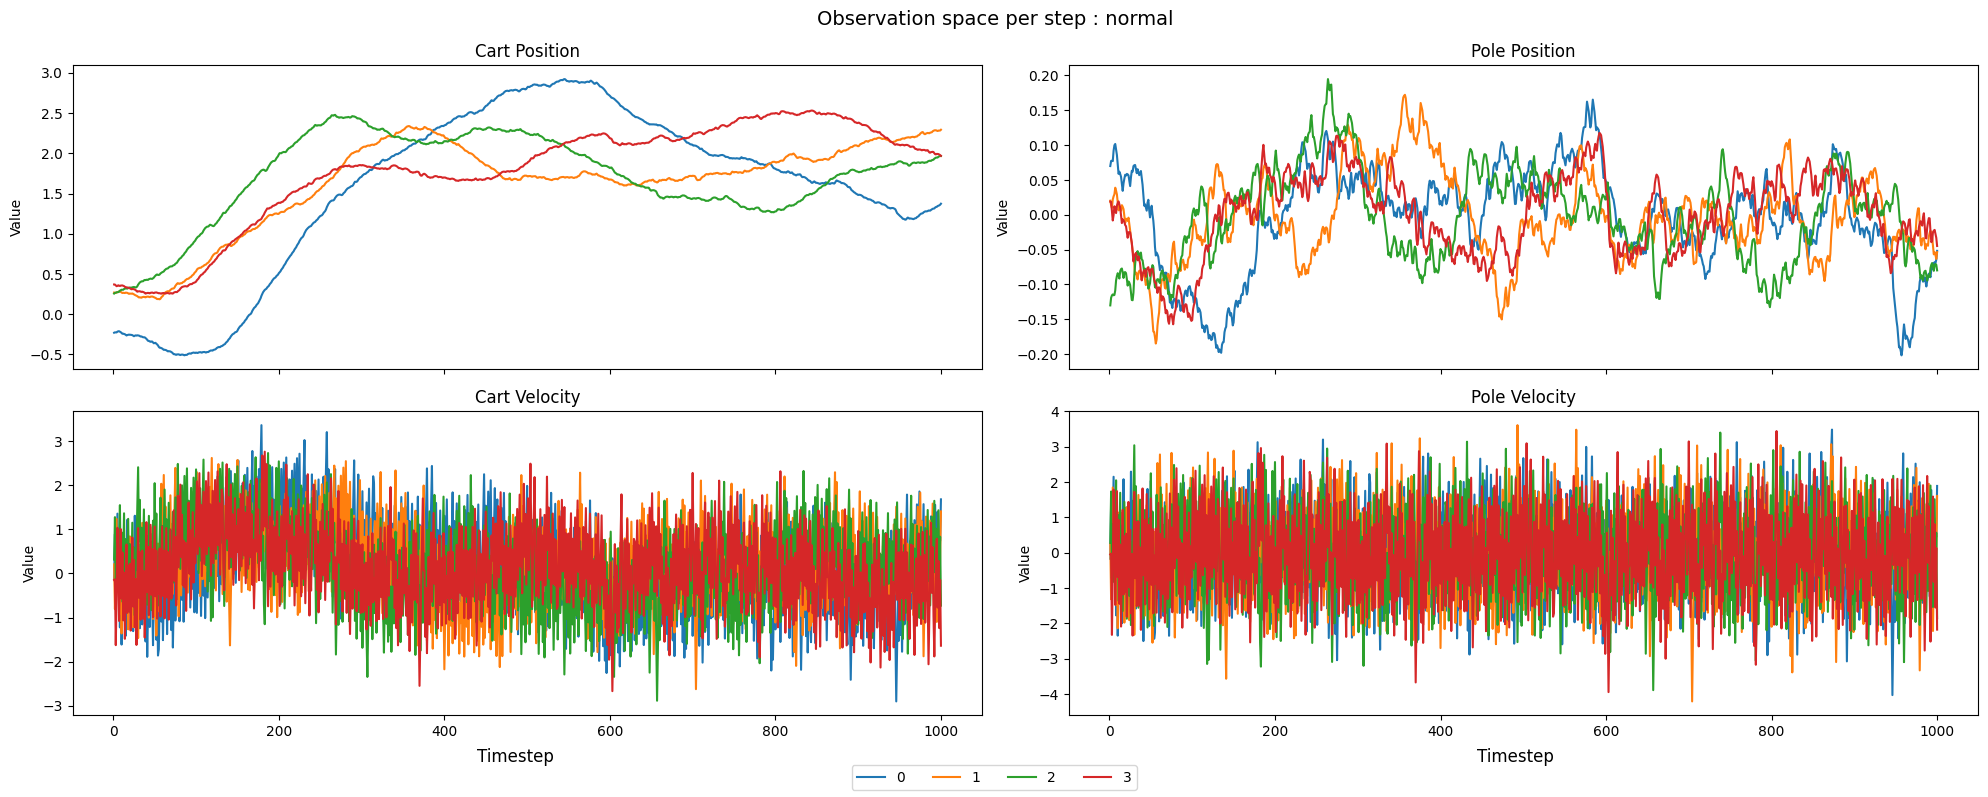

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_obs_policies(json_files, chart_labels,setup):
    """Loads multiple observation datasets from JSON and plots them in a single figure."""
    
    # Define labels for each value
    labels = ["Cart Position", "Pole Position", "Cart Velocity", "Pole Velocity"]
    
    # Create a 2x2 grid figure
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

    colors = ['C0', 'C1', 'C2', 'C3']  # Color cycle for different policies
    legend_handles = []  # Store handles for legend

    for file, label, color in zip(json_files, chart_labels, colors):
        # Load JSON data
        with open(file, 'r') as f:
            obs_history = json.load(f)

        # Convert nested structure to NumPy array
        obs_array = np.array([item[0] for item in obs_history])  

        # Generate timestep values
        timesteps = np.arange(1, obs_array.shape[0] + 1)

        # Plot each observation type in a 2x2 grid
        for i, ax in enumerate(axes.flat):
            line, = ax.plot(timesteps, obs_array[:, i], color=color, label=label)
            ax.set_title(labels[i])
            ax.set_ylabel("Value")
            ax.grid()

            if i == 0:  # Store legend handles only once
                legend_handles.append(line)

    # Add a common legend outside the plot
    fig.legend(handles=legend_handles, labels=chart_labels, loc='lower center', ncol=4)

    # Common x-axis label
    fig.text(0.52, 0.04, "Timestep", ha="center", fontsize=12)
    fig.text(1.52, 0.04, "Timestep", ha="center", fontsize=12)
    fig.suptitle(f"Observation space per step : {setup}", fontsize=14,x=1)

    plt.tight_layout(rect=[0, 0.05, 2, 1])  # Adjust layout to fit title and legend
    plt.show()

json_files = [
    "./Data/MCR/64_hidden/MCR_0_7_20.0.json",
    "./Data/MCR/64_hidden/MCR_1_7_20.0.json",
    "./Data/MCR/64_hidden/MCR_2_7_20.0.json",
]
chart_labels = ["0", "1", "2", "3"]

plot_obs_policies(json_files, chart_labels,"normal")


In Dropout tuning i found:

Dropout 0 and 0.3 are perform same but Dropout 0.1 in step around 1600 to 2100 are perform good at stabilize.

Then in this Experiment the best Dropout parameter for MC Reinforce is 0.1 and i will use this values to the next experiment tuning.

##### Hidden dimension

In [ ]:
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.005
hidden_dim = 64 # 32 128 
n_episodes = 5000
n_observations = 4
dropout = 0.1
discount = 0.95
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRhidden.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRhiddendura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRhiddenloss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

In Hidden dimension tuning i found:

From the reward and stabilize 64 Hidden are perform best follow by 32 Hidden and 128 hidden.

Then in this Experiment the best Hidden dimension for MC Reinforce is 64 and i will use this values to the next experiment tuning.

##### Learning rate

In [ ]:
num_of_action = 7
action_range = [-20.0, 20.0]  # [min, max]
learning_rate = 0.005 # 0.01 0.001
hidden_dim = 64
n_episodes = 5000
n_observations = 4
dropout = 0.1
discount = 0.95
device = torch.device(
"cuda" if torch.cuda.is_available() else
"mps" if torch.backends.mps.is_available() else
"cpu"
)

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; width: 100%;">
    <!-- Image 1 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRLr.png" alt="Image 1" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average Sum reward per 100 episode</p>
    </div>
    <!-- Image 2 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRLrdura.png" alt="Image 2" style="width: 100%; height: auto; border-radius: 10px;">
        <p>Average duration per 100 episode(max 1000)</p>
    </div>
    <!-- Image 3 -->
    <div style="text-align: center;">
        <img src="Picture/MCR/MCRLrloss.png" alt="Image 3" style="width: 100%; height: auto; border-radius: 10px;">
        <p>loss per 100 episode</p>
    </div>
</div>

In Learning rate tuning i found:

From the reward and stabilize if we increase Learning rate the agent seem learning more fast (as you can see in reward plot 0.01 are fast to reach maximum reward faster then 0.005) but in the performance overall reward of learning rate 0.005 seem much more than 0.01.if we reduce Learning rate too much (like 0.001) agent seem learn to slow and cant find the optimal solution (local optima stuck) but in this test not increase the episode if we increase the episode this learning rate maybe perform good than the other.

Then in this Experiment the best Hidden dimension for MC Reinforce is 64 and i will use this values to the next experiment tuning.

##### Summary MC Reinforce

#### Experiment 4 the Proximal Policy Optimization algorithm (PPO)

In this experiment will try to tune 3 hyperparameters:
- Learning rate : 0.0002 0.001 0.005
- hidden_dim : 32 64 128
- dropout : 0.0 0.1 0.3

### Why does it perform better than the others?